## PROJECT-3 (EDA + Feature Engineering)

### КАКОЙ КЕЙС РЕШАЕМ?

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

In [78]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
# Загружаем библиотеку для оценки значимости переменных (ANOVA):
from sklearn.feature_selection import f_classif

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# импортируем библиотеки для лингвистического анализа
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

# импортируем библиотеку математических функций
import math

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [79]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [80]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [81]:
# Подгрузим наши данные из соревнования

# DATA_DIR = '/kaggle/input/sf-booking/'
# df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
# df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
# sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

DATA_DIR = 'data'
df_train = pd.read_csv(DATA_DIR + '\\hotels_train.csv') # тренировочный датасет 
df_test = pd.read_csv(DATA_DIR+'\\hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'\\submission.csv') # самбмишн

### КРАТКАЯ ИНФОРМАЦИЯ О ДАННЫХ

In [82]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [83]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [84]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [85]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [86]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\anton\AppData\Local\Temp\ipykernel_13264\3925405557.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [87]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

### ДУБЛИРУЮЩИЕСЯ ЗАПИСИ

In [88]:
# Проанализируем датасет на наличие дублирующихся записей
data = df_train
dupl_columns = list(data.columns)
#dupl_columns.remove('id')

mask = data.duplicated(subset=dupl_columns)
data_duplicates = data[mask]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

Число найденных дубликатов: 307


In [89]:
# # удалять дубликаты не будем по совету ментора
# df_train = df_train.drop_duplicates(subset=dupl_columns)
# print(f'Результирующее число записей: {df_train.shape[0]}')

____________________________________________

### ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ

In [90]:
# Проверим датасет на наличие пропусков в данных
data = hotels
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

lat    0.633655
lng    0.633655
dtype: float64

In [91]:
# Сколько всего отелей представоено в выборке?
data = hotels
print(data['hotel_name'].value_counts())
print(len(pd.unique(data['hotel_name'])) )

Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3578
DoubleTree by Hilton Hotel London Tower of London    3212
                                                     ... 
Hotel Eitlj rg                                         12
Hotel Daniel Paris                                     12
Mercure Paris Porte d Orleans                          10
Hotel Wagner                                           10
Hotel Gallitzinberg                                     8
Name: hotel_name, Length: 1492, dtype: int64
1492


In [92]:
# # Сколько всего адресов отелей представоено в выборке?
data = hotels
print(data['hotel_address'].value_counts())
print(len(pd.unique(data['hotel_address'])) )

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
                                                                                  ... 
8 rue Fr d ric Bastiat 8th arr 75008 Paris France                                   12
2 4 Boundary Street Hackney London E2 7DD United Kingdom                            12
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                             10
13 Rue Fran ois Ory 92120 Paris France                                              10
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              8
Name: hotel_address, Length: 1493, dtype: i

___________________________________________

### СТРОКОВЫЕ ДАННЫЕ И НОВЫЕ ПРИЗНАКИ 

### hotel_address (адрес отеля)

In [93]:
# выделяем признаки страны и города отеля из признака hotel_address 
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: 'London' if x.split()[-2] == 'United' else x.split()[-2])
hotels.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_country,hotel_city
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,Milan
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,Amsterdam


In [94]:
# выясним сколько городов и стран расположения отелей представлено в выборке:
display(hotels.groupby(['hotel_country', 'hotel_city'])['hotel_country', 'hotel_city'].count())

C:\Users\anton\AppData\Local\Temp\ipykernel_13264\67807271.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  display(hotels.groupby(['hotel_country', 'hotel_city'])['hotel_country', 'hotel_city'].count())


,,hotel_country,hotel_city
hotel_country,hotel_city,,
Austria,Vienna,38939,38939
France,Paris,59928,59928
Italy,Milan,37207,37207
Netherlands,Amsterdam,57214,57214
Spain,Barcelona,60149,60149
United Kingdom,London,262301,262301


В каждой стране отели представлены только из одного города.  
В дальнейшем (после анализа остальных признаков) Можно оставить в выборке один из признаков - страну.

In [95]:
# кодируем информацию о стране с помощью метода доступа (accessor) cat.codes:
hotels['hotel_country'] = hotels['hotel_country'].astype('category')
hotels['hotel_country_code'] = hotels['hotel_country'].cat.codes
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,hotel_country,hotel_city,hotel_country_code
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,Milan,2
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,Amsterdam,3
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Spain,Barcelona,4
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0,Italy,Milan,2
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0,Netherlands,Amsterdam,3


In [96]:
# удалим нечисловой признак hotel_address
hotels = hotels.drop(['hotel_address'], axis=1) 

___________________________________________

### reviewer_nationality (национальность рецензента)

Создадаим новый признак резиденства рецензента (вероятно это оказывает влияние на итоговоую оценку), а также закодируем информацию о стране рецензента.

In [97]:
# добавим признак резидентства туриста по отношению к стране, в которой находится отель:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())
hotels['hotel_country'] = hotels['hotel_country'].apply(lambda x: x.strip())
hotels['reviewer_resident'] = hotels.apply(lambda row: 1 if row['reviewer_nationality'] == row['hotel_country'] else 0, axis=1)

In [98]:
# кодируем информацию о стране рецензента:
hotels['reviewer_nationality_code'] = hotels['reviewer_nationality'].astype('category').cat.codes
hotels.head(2)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,days_since_review,lat,lng,sample,reviewer_score,hotel_country,hotel_city,hotel_country_code,reviewer_resident,reviewer_nationality_code
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,13 days,45.533137,9.171102,0,0.0,Italy,Milan,2,0,214
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,234 day,52.385649,4.834443,0,0.0,Netherlands,Amsterdam,3,0,22


In [99]:
# удалим нечисловой признак	reviewer_nationality:
hotels.drop('reviewer_nationality', axis=1, inplace=True)

____________________________________________________

### tags (теги)

Определим количество и состав групп тегов:

In [100]:
# определим функцию для выделения отдельных тегов из признака tags:
def tags(string):
    string = string.replace('[', '').replace(']', '')
    string = string.replace("' ", '').replace(" '", '')
    tags_list = string.split(',')
    tags_list = list(map(lambda x: x.strip(), tags_list))
    return tags_list
# применим данную функцию к значениям признака tags:  
df = pd.DataFrame(hotels['tags'].apply(tags).to_list(), index=hotels.index)
display(df)

,0,1,2,3,4,5
0,Leisure trip,Couple,Double Room,Stayed 2 nights,None,None
1,Leisure trip,Group,Triple Room,Stayed 1 night,None,None
2,Business trip,Solo traveler,Twin Room,Stayed 1 night,Submitted from a mobile device,None
3,Leisure trip,Couple,Ambassador Junior Suite,Stayed 1 night,None,None
4,Business trip,Solo traveler,Classic Double or Twin Room,Stayed 2 nights,Submitted from a mobile device,None
...,...,...,...,...,...,...
515733,Leisure trip,Group,Club Double or Twin Room,Stayed 2 nights,Submitted from a mobile device,None
515734,Leisure trip,Couple,Standard Double Room,Stayed 4 nights,Submitted from a mobile device,None
515735,Business trip,Solo traveler,Single Room,Stayed 1 night,None,None
515736,Leisure trip,Solo traveler,Deluxe Double Room,Stayed 2 nights,None,None


In [101]:
# # определим количество уникальных тегов
# set1 = set()
# df = hotels.copy()
# for i in df['tags']:
#     # string = i.replace('[', '').replace(']', '')
#     # string = string.replace("' ", '').replace(" '", '')
#     string = i.replace('[', '').replace(']', '').replace("'", '')
#     tags_list = string.split(',')
#     tags_list = list(map(lambda x: x.strip(), tags_list)) 
#     for j in range(0, len(tags_list)):  
#         set1.add(tags_list[j])
# print (len(set1))



tags = set()
for index, value in hotels['tags'].items():
        pre_tags = value
        pre_tags = pre_tags[2:-2]
        pre_tags = pre_tags.split('\', \'')
        for i in pre_tags:
            tags.add(i.strip())
print(len(tags))


# my_str = "['яблоко', 'апельсин', 'банан']"

# # Данная программа будет работать
# my_str = my_str[2:-2]
# new_my_str = my_str.split('\', \'')

# print(new_my_str)

# # Данная программа НЕ будет работать
# my_str = my_str[2:-2]
# new_my_str = my_str.split('', '')


2428


Видим, что максимальное количество тэгов = 6.   
Считаю, что оказывающими влияние на оценку рецензента являются теги, характерезующие тип путешествия и состав группы путешественников.  
Создадим для них отдельные признаки.

In [102]:
# воспользуемся функцией-мигалкой для поиска ключевых слов в признаке tags:  
def get_flasher(data, key):
    """Алгоритм проверки наличия ключевого слова в исходном признаке ('tags')

    Args:
        data (object): исходный признак потенциально содержащий ключевое слово
        key (str): ключевое слово

    Returns:
        int: признак наличия ключевого слова в признаке
    """  
    # Получение признака-мигалки:   
    if key in str(data):
        return 1
    else:
        return 0
    
# Теперь применим эту функцию к столбцу tags 
# в качестве аргумента передадим ключевое слово:  
key_words = ['Leisure trip','Business trip', 'Couple', 'Group', 'Solo traveler', 'Family with young children ', 'With a pet', 'Family with older children', 'Travelers with friends']
for key_word in key_words:
    hotels[key_word] = hotels['tags'].apply(get_flasher, key=key_word) 
hotels.head()

,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,reviewer_nationality_code,Leisure trip,Business trip,Couple,Group,Solo traveler,Family with young children,With a pet,Family with older children,Travelers with friends
0,904,7/21/2017,8.1,Hotel Da Vinci,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,214,1,0,1,0,0,0,0,0,0
1,612,12/12/2016,8.6,Urban Lodge Hotel,No tissue paper box was present at the room,10,5018,No Positive,0,7,...,22,1,0,0,1,0,0,0,0,0
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Pillows,3,351,Nice welcoming and service,5,15,...,196,0,1,0,0,1,0,0,0,0
3,241,10/17/2015,9.1,Hotel Principe Di Savoia,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,...,216,1,0,1,0,0,0,0,0,0
4,834,5/16/2016,9.1,Hotel Esther a,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,...,214,0,1,0,0,1,0,0,0,0


In [103]:
# удалим нечисловой признак tags
hotels = hotels.drop(['tags'], axis=1) 

_____________________________________________

### lat, lng (географическая широта и долгота отеля)

Одной из основных характеристик отеля является удаленрность от центра города (соответственно удаленность от основаных достопримечательностей).


Выясним у каких отелей отсуствуют координаты:

In [104]:
print (hotels[(hotels['lat'].isnull() == True) | (hotels['lng'].isnull() == True)]['hotel_name'].value_counts())

Fleming s Selection Hotel Wien City                 658
Hotel City Central                                  563
Hotel Atlanta                                       389
Maison Albar Hotel Paris Op ra Diamond              290
Hotel Daniel Vienna                                 245
Hotel Pension Baron am Schottentor                  223
Austria Trend Hotel Schloss Wilhelminenberg Wien    194
Derag Livinghotel Kaiser Franz Joseph Vienna        147
NH Collection Barcelona Podium                      146
City Hotel Deutschmeister                            93
Hotel Park Villa                                     61
Cordial Theaterhotel Wien                            57
Holiday Inn Paris Montmartre                         55
Roomz Vienna                                         49
Mercure Paris Gare Montparnasse                      37
Renaissance Barcelona Hotel                          33
Hotel Advance                                        28
Name: hotel_name, dtype: int64


Для поиска географических координат по названию отеля воспользуемся сервисом 
https://yandex.ru/maps/

In [105]:
# сформируем датафрейм с координатами данных отелей
hotels_coord = pd.DataFrame(
    data = [
        ['Fleming s Selection Hotel Wien City', 48.209912, 16.353475],
        ['Hotel City Central', 48.213820, 16.379940],
        ['Hotel Atlanta', 48.220582, 16.355839],
        ['Maison Albar Hotel Paris Op ra Diamond', 48.875552, 2.323406],
        ['Hotel Daniel Vienna', 48.201786, 16.383623],
        ['Hotel Pension Baron am Schottentor', 48.217565, 16.359898],
        ['Austria Trend Hotel Schloss Wilhelminenberg Wien', 48.230262, 16.288146],
        ['Derag Livinghotel Kaiser Franz Joseph Vienna', 48.247220, 16.341362],
        ['NH Collection Barcelona Podium', 41.391870, 2.177931],
        ['City Hotel Deutschmeister', 48.221165, 16.366697],
        ['Hotel Park Villa', 48.233680, 16.345611],
        ['Cordial Theaterhotel Wien', 48.209970, 16.351540],
        ['Holiday Inn Paris Montmartre', 48.889344, 2.333228],
        ['Roomz Vienna', 48.227727, 16.394500],
        ['Mercure Paris Gare Montparnasse', 48.839648, 2.323477],
        ['Renaissance Barcelona Hotel', 41.392344, 2.167550],
        ['Hotel Advance', 41.383836, 2.163012]
    ],
    columns= ['hotel_name', 'lat', 'lng']
)
hotels_coord.head()

,hotel_name,lat,lng
0,Fleming s Selection Hotel Wien City,48.209912,16.353475
1,Hotel City Central,48.213820,16.379940
2,Hotel Atlanta,48.220582,16.355839
3,Maison Albar Hotel Paris Op ra Diamond,48.875552,2.323406
4,Hotel Daniel Vienna,48.201786,16.383623


Дополним данными о координатах этих отелей основной датасет:

In [106]:
for index_1, hotel_name_1 in enumerate (hotels_coord['hotel_name']):
    for index_2, hotel_name_2 in enumerate (hotels['hotel_name']):
        if hotel_name_1 == hotel_name_2:
            hotels.loc[index_2,'lat'] = hotels_coord.loc[index_1,'lat']
            hotels.loc[index_2,'lng'] = hotels_coord.loc[index_1,'lng']

Проверим еще раз остались ли отели с резаполненными координатами:

In [107]:
print (hotels[(hotels['lat'].isnull() == True) | (hotels['lng'].isnull() == True)]['hotel_name'].value_counts())

Series([], Name: hotel_name, dtype: int64)


In [108]:
hotels[hotels['hotel_name'].isin(hotels_coord['hotel_name'].to_list())]

,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,reviewer_nationality_code,Leisure trip,Business trip,Couple,Group,Solo traveler,Family with young children,With a pet,Family with older children,Travelers with friends
35,214,10/13/2016,7.8,Hotel Atlanta,The reception staff are somewhat dour and cou...,21,2724,The hotel is pretty from the outside and quai...,60,64,...,14,1,0,1,0,0,0,0,0,0
293,214,8/20/2015,7.8,Hotel Atlanta,It is an old hotel with old furniture The roo...,26,2724,The price and the service,7,17,...,196,1,0,0,0,0,0,0,1,0
476,44,5/1/2017,8.0,City Hotel Deutschmeister,WIFI is low speed,5,675,Good room good breakfast and good service,9,1,...,199,1,0,0,1,0,0,0,0,0
526,21,9/14/2015,8.3,Holiday Inn Paris Montmartre,No Negative,0,298,Helpful staff Breakfast plenty of choice Nice...,9,1,...,216,1,0,1,0,0,0,0,0,0
569,333,6/4/2016,8.3,Fleming s Selection Hotel Wien City,Food quality and price private shower bathroo...,25,3672,Location was good for walking into Vienna cen...,10,9,...,214,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515027,211,3/19/2017,8.6,Hotel City Central,Room could have been bigger slightly cramped ...,11,2923,Friendly and very helpful staff,7,2,...,94,0,1,0,0,1,0,0,0,0
515400,211,7/4/2017,8.6,Hotel City Central,Very expensive parking We thought it was 24 f...,24,2923,Central location and excellent breakfast,6,10,...,214,1,0,1,0,0,0,0,0,0
515439,172,7/10/2017,8.8,Maison Albar Hotel Paris Op ra Diamond,The rooms were a little small,7,1524,The staff were extremely helpful and friendly...,20,4,...,19,1,0,0,0,0,1,0,0,0
515637,211,11/7/2016,8.6,Hotel City Central,No Negative,0,2923,Great location close to a metro station and c...,19,6,...,101,0,1,0,0,1,0,0,0,0


Для расчета расстояния от отеля до воспользуемся данными о координатах центров городов с сайта  
https://time-in.ru/coordinates/  
а также формулу:  
d = arccos {sin(Фa)·sin(Фb) + cos(Фa)·cos(Фb)·cos(Лa - Лb)}, где Фa и Фb — широты, Лa, Лb — долготы данных пунктов, d — расстояние между пунктами, измеряемое в радианах длиной дуги большого круга земного шара.  
Расстояние между пунктами, измеряемое в километрах, определяется по формуле:
L = d·R, где R = 6371 км — средний радиус земного шара.

In [109]:
def km_to_center(hotel_city, lat, lng):
    """Алгоритм получения расстояния между географическими координатами отеля и центра города

    Args:
        hotel_city (object): город, в котором раходится отель;
        lat (object): географическая широта отеля
        lng (object): географическая долгота отеля

    Returns:
        int: расстояние в км
    """ 
    # сформируем датафрейм с координатами центров городов
    centers = pd.DataFrame(
    data = [
        ['Austria', 'Vienna', 48.20849, 16.37208],
        ['Italy', 'Milan', 45.46427, 9.18951],
        ['United Kingdom', 'London', 51.50853, -0.12574],
        ['France', 'Paris', 48.85341, 2.34880],
        ['Spain', 'Barcelona', 41.38879, 2.15899],
        ['Netherlands', 'Amsterdam', 52.37403, 4.88969]
    ],
    columns= ['country', 'hotel_city', 'lat', 'lng']).set_index('country')
    
    # зададим формулу для расчета расстояния
    d = math.acos((math.sin(centers[centers['hotel_city'] == hotel_city]['lat']*math.pi/180)*math.sin(lat*math.pi/180)) + (math.cos(centers[centers['hotel_city'] == hotel_city]['lat']*math.pi/180)*math.cos(lat*math.pi/180)*math.cos(centers[centers['hotel_city'] == hotel_city]['lng']*math.pi/180-lng*math.pi/180)))
    L = round(d*6371, 1)
    return L
   
# применим функцию km_to_center к столбцу 'hotel_city':  
hotels['km_to_center'] = hotels.apply(lambda row: km_to_center(row['hotel_city'], row['lat'], row['lng']), axis=1)


In [110]:
hotels.head(2)

,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,Leisure trip,Business trip,Couple,Group,Solo traveler,Family with young children,With a pet,Family with older children,Travelers with friends,km_to_center
0,904,7/21/2017,8.1,Hotel Da Vinci,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,1,0,1,0,0,0,0,0,0,7.8
1,612,12/12/2016,8.6,Urban Lodge Hotel,No tissue paper box was present at the room,10,5018,No Positive,0,7,...,1,0,0,1,0,0,0,0,0,4.0


In [111]:
# теперь столбцы с координатами можно удалить:
hotels.drop(['lng', 'lat'], axis=1, inplace=True)

In [112]:
# также можно удалить нечисловые признаки hotel_city, hotel_country (далее они не используются):
hotels = hotels.drop(['hotel_city', 'hotel_country'], axis=1) 

______________________________________

### negative_review, positive_review (отзывы)

Для проведения лингвистического анализа отзывов используем модуль Vader.

В связи с некорректной трактовкой анализатором таких слов как "No Negative" и "No Positive" и т.д. необходимо внести дополнения в словари рнегативного и позитивного лексикона.

In [113]:
%%time
# создаем два экземпляра анализатора для  оценки положительных и отрицательных отзывов:
sia_positive = SentimentIntensityAnalyzer()
sia_negative = SentimentIntensityAnalyzer()

# добавим контекст в словари:
neg_words = {'small': -1, 'nothing': 10, 'no negative':10, 'none':10, 'all good':10, 'liked everything':10, 'everything was great':10, 'everything was perfect':10, 'no':10, 'non':10, 'can t think of anything':10, 'nil':10, 'na':10}
pos_words = {'nothing': -10, 'everything': 10, }
sia_negative.lexicon.update(neg_words)
sia_positive.lexicon.update(pos_words)

# формируем новые признаки c общими результатами оценки:
hotels['negative_review_sentiments'] = hotels['negative_review'].apply(lambda x: sia_negative.polarity_scores(x))
hotels['positive_review_sentiments'] = hotels['positive_review'].apply(lambda x: sia_positive.polarity_scores(x))

# формируем новые признаки для негативного отзыва:
hotels['n_review_sentiments_neg'] = hotels['negative_review_sentiments'].apply(lambda x: x['neg'])
hotels['n_review_sentiments_neu'] = hotels['negative_review_sentiments'].apply(lambda x: x['neu'])
hotels['n_review_sentiments_pos'] = hotels['negative_review_sentiments'].apply(lambda x: x['pos'])
hotels['n_review_sentiments_compound'] = hotels['negative_review_sentiments'].apply(lambda x: x['compound'])

# формируем новые признаки для позитивного отзыва:
hotels['p_review_sentiments_neg'] = hotels['positive_review_sentiments'].apply(lambda x: x['neg'])
hotels['p_review_sentiments_neu'] = hotels['positive_review_sentiments'].apply(lambda x: x['neu'])
hotels['p_review_sentiments_pos'] = hotels['positive_review_sentiments'].apply(lambda x: x['pos'])
hotels['p_review_sentiments_compound'] = hotels['positive_review_sentiments'].apply(lambda x: x['compound'])



CPU times: total: 2min 38s
Wall time: 2min 38s


In [114]:
# теперь столбцы с нечисловыми общими результатами оценки:
hotels.drop(['positive_review', 'negative_review', 'negative_review_sentiments', 'positive_review_sentiments'], axis=1, inplace=True)

In [115]:
hotels.head(2)

,additional_number_of_scoring,review_date,average_score,hotel_name,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,sample,...,Travelers with friends,km_to_center,n_review_sentiments_neg,n_review_sentiments_neu,n_review_sentiments_pos,n_review_sentiments_compound,p_review_sentiments_neg,p_review_sentiments_neu,p_review_sentiments_pos,p_review_sentiments_compound
0,904,7/21/2017,8.1,Hotel Da Vinci,52,16670,62,1,13 days,0,...,0,7.8,0.063,0.602,0.335,0.9738,0.000,0.671,0.329,0.9615
1,612,12/12/2016,8.6,Urban Lodge Hotel,10,5018,0,7,234 day,0,...,0,4.0,0.000,0.421,0.579,0.9325,0.379,0.000,0.621,0.3400


___________________________________

### review_date (дата размещения отзыва) 

Предполагаю, что ни дата размещения отзыва как таковая, ни сезонность даты не влияют на итоговую оценку. Удалим данный признак. 

In [116]:
# удалим столбец review_date:
hotels.drop('review_date', axis=1, inplace=True)

____________________________________________

### days_since_review (количество дней после отзыва)

Предположим, что время прошедшее после отзыва должно оказывать влияние на итоговую оценку т.к. владельцы и персонал отеля в разные периоды времени могли как улучшить его привлекательность, так и снизить ее, таким образом для точности предсказания оценки количество дней после отзыва может оказаться значимым.  
Выделим количество дней из признака days_since_review:

In [117]:
hotels_copy  = hotels.copy()
# определим функцию для выделения количества дней из признака days_since_review:
def days (string):
    """Алгоритм получения количества дней из признака days_since_review

    Args:
        string (object): исходное значение признака;

    Returns:
        int: количество дней
    """    
    list = string.split(' ')
    days_str = list[0] 
    days_int = int(days_str.strip())
    return days_int
# применим данную функцию к значениям признака ays_since_review:  
hotels['days_since_review'] = hotels['days_since_review'].apply(days)
hotels['days_since_review']

0          13
1         234
2         616
3         656
4         444
         ... 
515733    106
515734    171
515735    543
515736     74
515737    363
Name: days_since_review, Length: 515738, dtype: int64

_______________________________________________________

### review_total_positive_word_counts, review_total_negative_word_counts (количество позитивных и негативных слов в отзыве)

Вероятно, что на итоговую оценку в большей мере влияет не количество негативных (позитивных) слов в отзыве, а их доля в общем количестве слов отзыва (насыщенность отзыва такими словами)

In [118]:
# добавим признаки доли позитивных и негативных слов в расчете на один отзыв
hotels['positive_words_per_review'] = hotels['review_total_positive_word_counts'] / hotels['total_number_of_reviews_reviewer_has_given']
hotels['negative_words_per_review'] = hotels['review_total_negative_word_counts'] / hotels['total_number_of_reviews_reviewer_has_given']

_________________________________________________________________________

### hotel_name (название отеля)

Название отеля врядли несет какую-то полезную информацию для обучения модели (скорее наоборот). Удалим данный признак из датасета.

In [119]:
# удалим столбец hotel_name:
hotels.drop('hotel_name', axis=1, inplace=True)

In [120]:
hotels.head(2)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,sample,reviewer_score,hotel_country_code,...,n_review_sentiments_neg,n_review_sentiments_neu,n_review_sentiments_pos,n_review_sentiments_compound,p_review_sentiments_neg,p_review_sentiments_neu,p_review_sentiments_pos,p_review_sentiments_compound,positive_words_per_review,negative_words_per_review
0,904,8.1,52,16670,62,1,13,0,0.0,2,...,0.063,0.602,0.335,0.9738,0.000,0.671,0.329,0.9615,62.0,52.000000
1,612,8.6,10,5018,0,7,234,0,0.0,3,...,0.000,0.421,0.579,0.9325,0.379,0.000,0.621,0.3400,0.0,1.428571


______________________________________________________

## ОТБОР ПРИЗНАКОВ

In [121]:
hotels_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   hotel_name                                  515738 non-null  object 
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   days_since_review                           515738 non-null  object 
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

Проверим наличие столбцов с нечисловыми признаками:

In [122]:
print(f'Текущее получившееся количество признаков: {len(hotels_copy.columns)}')
print('(включая целевой столбец и метку тест/трейн)')

# удалим нечисловые данные:
object_columns = [s for s in hotels.columns
                  if ((hotels[s].dtypes == 'object') | \
                      (hotels[s].dtype.name == 'category') | \
                      (hotels[s].dtypes == 'datetime64[ns]'))]

print(f'Удалим {len(object_columns)} столбцов с нечисловыми данными')
# hotels = hotels.drop(object_columns, axis = 1)

Текущее получившееся количество признаков: 31
(включая целевой столбец и метку тест/трейн)
Удалим 0 столбцов с нечисловыми данными


_________________________________

### АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ ПРИЗНАКОВ

In [123]:
# построим тепловую диаграму корреляции признаков
pivot = hotels.corr()
pivot = pivot.drop('sample', axis=1)
fig = px.imshow(pivot, width=1100, height=1100)
fig.show()

Удалим признаки, сильно коррелирующие с другими признаками (с коэффициентом корреляции более 0,80):

In [124]:
hotels = hotels.drop(['additional_number_of_scoring', 'Leisure trip', 'n_review_sentiments_neu', 'p_review_sentiments_pos'] , axis = 1)

______________________________________________

### ОЦЕНКА ЗНАЧИМОСТИ ПРИЗНАКОВ

Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn (в основе метода оценки значимости переменных лежит анализ ANOVA)

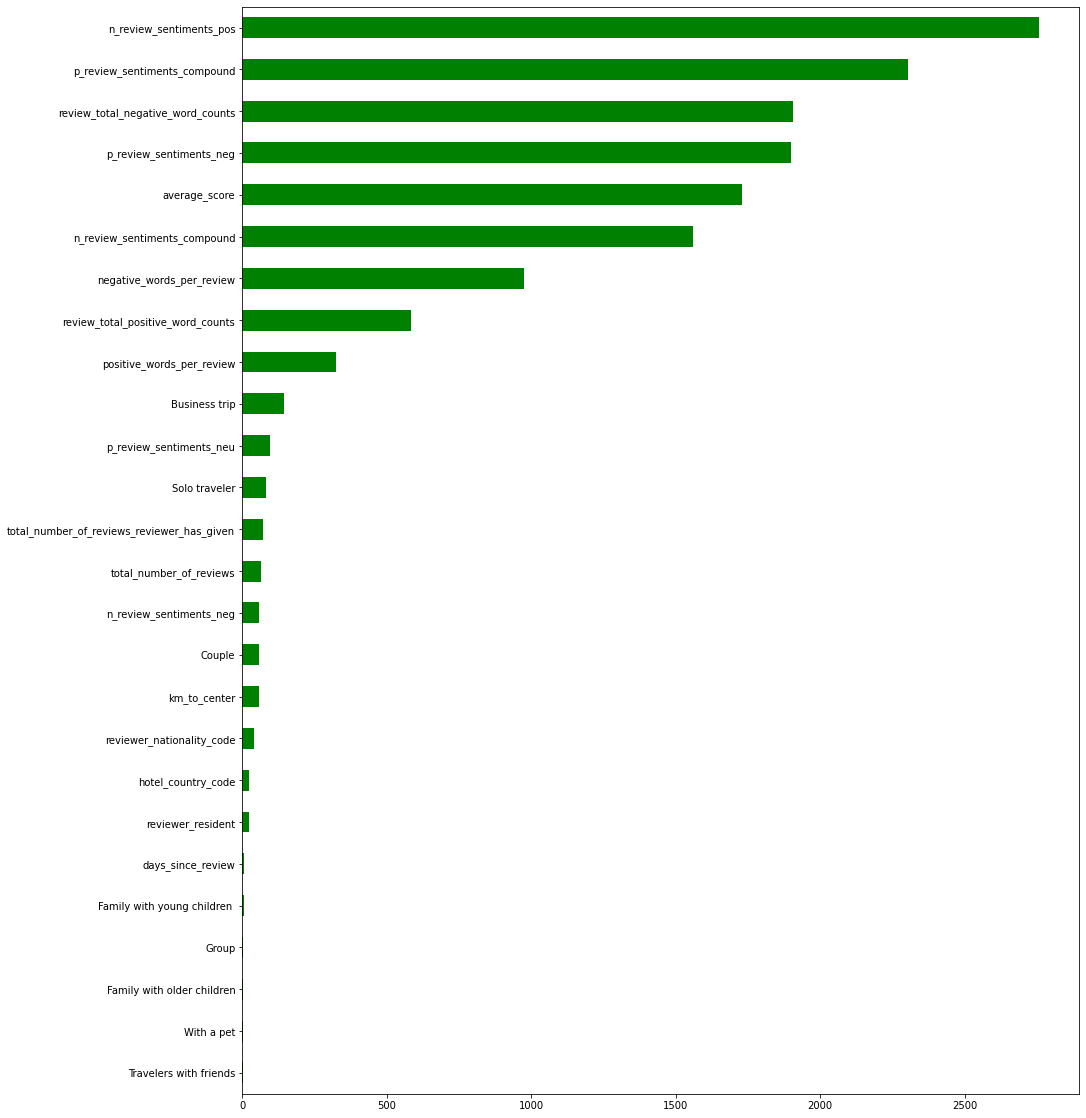

In [125]:
hotels_copy = hotels.copy()
y = hotels_copy.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = hotels_copy.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='green');

Удалим признак, у которого отсутствует корреляция с целевым (Group):

In [126]:
hotels = hotels.drop('Group', axis = 1)

______________________________________

###  ОБУЧЕНИЕ МОДЕЛИ И ПОЛУЧЕНИЕ ПРЕДСКАЗАНИЯ 

In [127]:
# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [128]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [129]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [130]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [131]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1214800364338281


<AxesSubplot:>

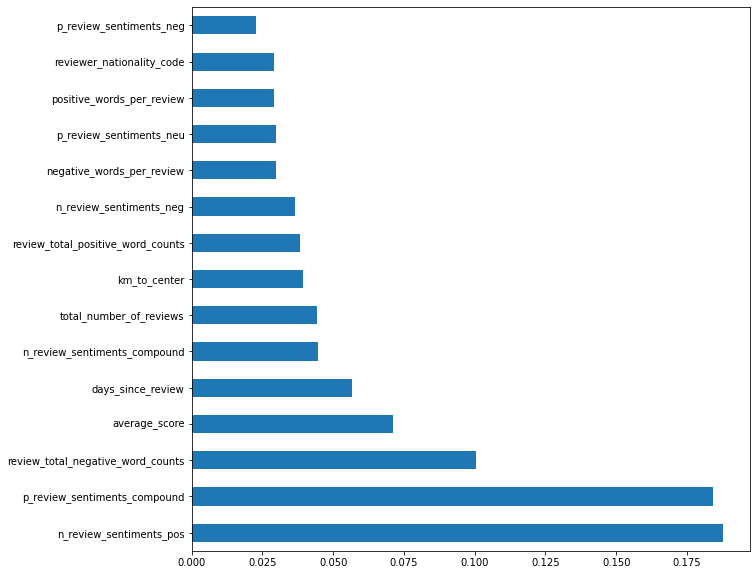

In [132]:
# Выведем самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [133]:
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = regr.predict(test_data)
sample_submission['reviewer_score'] = predict_submission

#  сохраняем результат:
sample_submission.to_csv('data\submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.703,488440
1,7.459,274649
2,7.908,374688
3,9.880,404352
4,9.469,451596
5,8.729,302161
6,7.420,317079
7,7.776,13963
8,8.303,159785
9,7.510,195089


По итогам моделирования среди 15 наиболее значимых признаков 5 остались в первоначальном виде, 8 признаков спроектированы вновь и 2 признака подверглись дополнительной обработке и кодированию. Ожидаемо по степени влияния на результат моделирования лидируют признаки полученные в ходе лингвистического анализа отзывов. Итоговая средняя абсолютная процентная ошибка снижена на 14%.